In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set the font family to Times New Roman
# import matplotlib.pyplot as plt
# from matplotlib import font_manager

# font_path = 'fig/times.ttf'  # Your font path goes here
# font_manager.fontManager.addfont(font_path)
# prop = font_manager.FontProperties(fname=font_path)

# plt.rcParams['font.family'] = 'sans-serif'
# plt.rcParams['font.sans-serif'] = prop.get_name()

In [38]:
df = pd.read_csv('./final_results/cifar10_results.csv')

In [39]:
import matplotlib.font_manager as fm

# Set the path to the Times New Roman font file
pd.set_option('display.max_colwidth', 1000)

In [40]:

title_font_size = 22
axis_label_font_size = 22
tick_label_font_size = 16

In [41]:
import pandas as pd


kernal_df = pd.DataFrame(columns=['KSCE', 'KDECE', 'MMCE', 'test-accuracy'])

for index, row in df.iterrows():
    ksce_data = eval(row['KSCE'])
    kdece_data = eval(row['KDECE'])
    mmce_data = eval(row['MMCE'])
    
    bins_data = {
        'KSCE': ksce_data['result'],
        'KDECE': kdece_data['result'],
        'MMCE': mmce_data['result'],
        'test-accuracy': row['info']*100
    }
    
    # Create a DataFrame from the extracted data and concatenate it to the new DataFrame
    data_to_append = pd.DataFrame([bins_data])
    kernal_df = pd.concat([kernal_df, data_to_append], ignore_index=True)

/tmp/ipykernel_2425318/1585665066.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.2f}'.format(tick) for tick in ax.get_yticks()], fontsize=12)
/tmp/ipykernel_2425318/1585665066.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.2f}'.format(tick) for tick in ax.get_yticks()], fontsize=12)
/tmp/ipykernel_2425318/1585665066.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.2f}'.format(tick) for tick in ax.get_yticks()], fontsize=12)


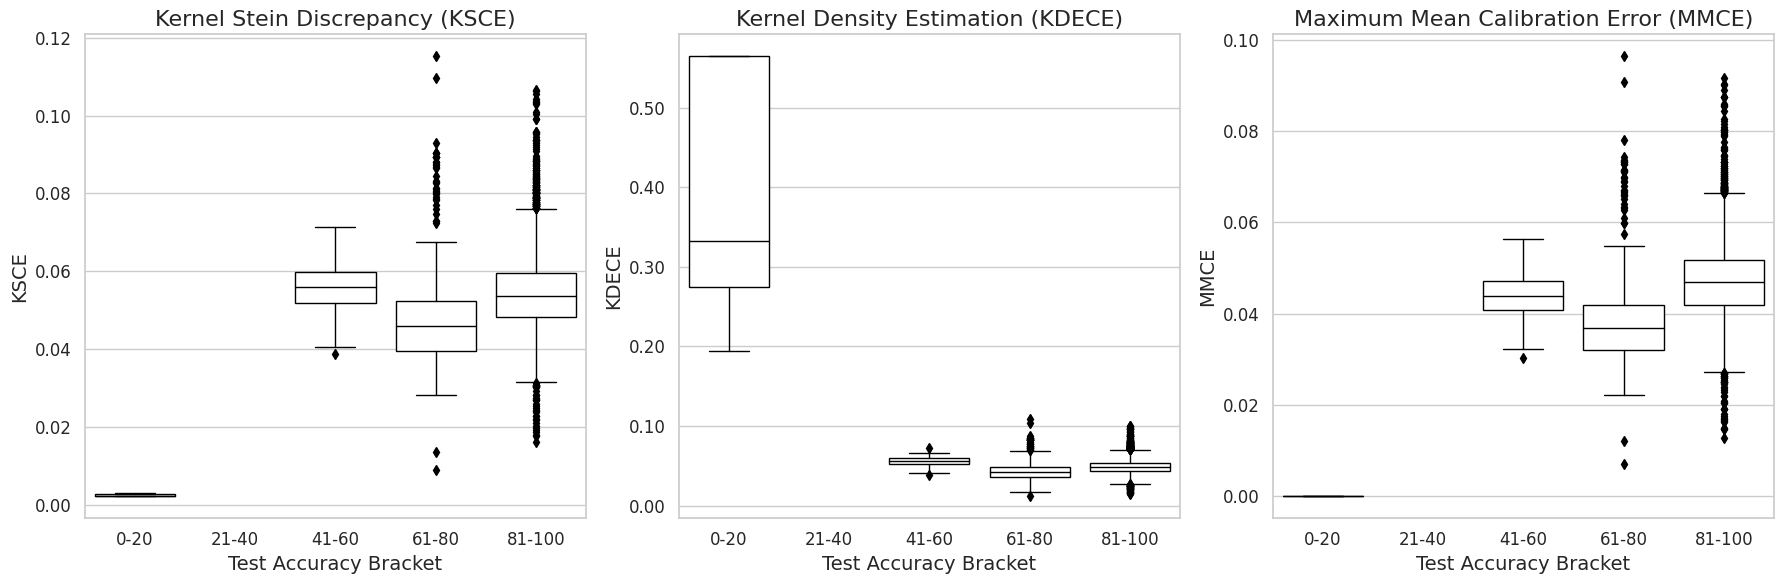

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming kernal_df is your DataFrame with 'KSCE', 'KDECE', 'MMCE', and 'test-accuracy'

def categorize_test_accuracy(accuracy):
    if 0 <= accuracy <= 20:
        return '0-20'
    elif 20 < accuracy <= 40:
        return '21-40'
    elif 40 < accuracy <= 60:
        return '41-60'
    elif 60 < accuracy <= 80:
        return '61-80'
    else:
        return '81-100'

kernal_df['accuracy_bracket'] = kernal_df['test-accuracy'].apply(categorize_test_accuracy)

# Create a 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.set(style="whitegrid")

titles = [
    "Kernel Stein Discrepancy (KSCE)",
    "Kernel Density Estimation (KDECE)",
    "Maximum Mean Calibration Error (MMCE)"
]

ylabels = ["KSCE", "KDECE", "MMCE"]
metrics = ['KSCE', 'KDECE', 'MMCE']

for i, metric in enumerate(metrics):
    ax = axes[i]

    plot_data = []
    for bracket in ['0-20', '21-40', '41-60', '61-80', '81-100']:
        plot_data.append(kernal_df.loc[kernal_df['accuracy_bracket'] == bracket, metric])

    sns.boxplot(data=plot_data,
                ax=ax,
                boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
                capprops=dict(color='black', linewidth=1),
                whiskerprops=dict(color='black', linewidth=1),
                medianprops=dict(color='black', linewidth=1),
                flierprops=dict(markeredgecolor='black', markerfacecolor='black', markersize=5))

    ax.set_title(titles[i], fontsize=16)
    ax.set_xlabel("Test Accuracy Bracket", fontsize=14)
    ax.set_ylabel(ylabels[i], fontsize=14)

    ax.set_xticklabels(['0-20', '21-40', '41-60', '61-80', '81-100'], fontsize=12)
    ax.set_yticklabels(['{:.2f}'.format(tick) for tick in ax.get_yticks()], fontsize=12)
# Adjust spacing between subplots
fig.tight_layout()

# Save the figure
# plt.savefig("fig/cifar10_kernal_metrics_single_row.pdf", dpi=300, format='pdf', bbox_inches='tight')

# Show the figure
plt.show()

In [43]:
import pandas as pd

# Assuming `df` is your original DataFrame and 'ece' column contains list of dictionaries
# Create an empty DataFrame with desired columns
ece_df = pd.DataFrame(columns=['5_bins', '10_bins', '15_bins', '20_bins', '25_bins', '50_bins', '100_bins', '200_bins', '500_bins','test-accuracy'])

# Iterate through the original DataFrame and extract the relevant information
for index, row in df.iterrows():
    ece_data = eval(row['ece'])
    
    bins_data = {}
    for item in ece_data:
        bins_data[f"{item['n_bins']}_bins"] = item['result']
    
    bins_data['test-accuracy'] = row['info']*100
    
    # Append the extracted data to the new DataFrame
    data_to_append = pd.DataFrame([bins_data])
    ece_df = pd.concat([ece_df, data_to_append], ignore_index=True)

plot_df = ece_df.loc[ece_df['test-accuracy']>= 75]



In [45]:
plot_df.columns

Index(['5_bins', '10_bins', '15_bins', '20_bins', '25_bins', '50_bins',
       '100_bins', '200_bins', '500_bins', 'test-accuracy'],
      dtype='object')

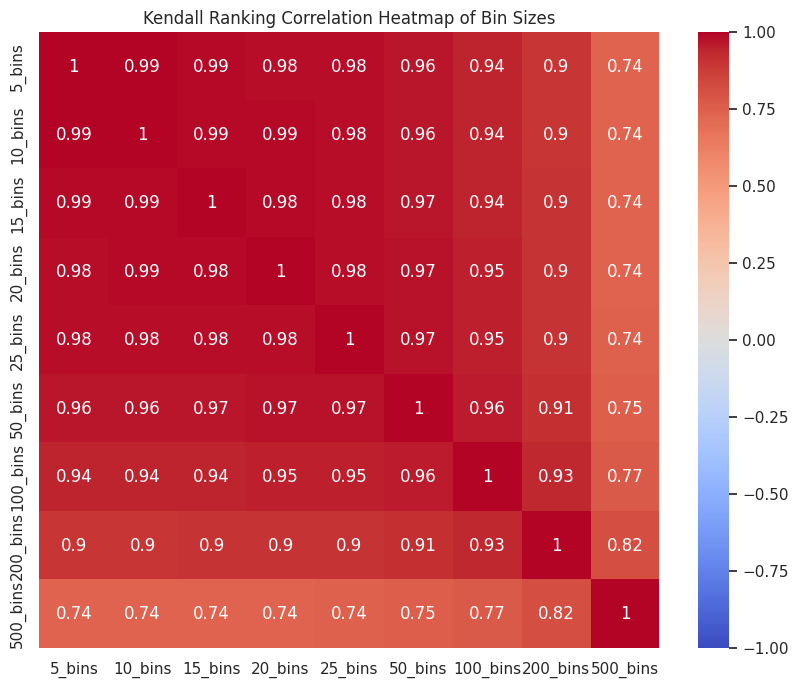

In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kendalltau

def nansafe_kendalltau(a, b):
    mask = ~(np.isnan(a) | np.isnan(b))
    return kendalltau(a[mask], b[mask])

# Extract bin columns from plot_df
bin_columns = ['5_bins', '10_bins', '15_bins', '20_bins', '25_bins', '50_bins', '100_bins', '200_bins', '500_bins']

# Calculate the Kendall ranking correlation matrix for the bin columns
corr_matrix = pd.DataFrame(index=bin_columns, columns=bin_columns)

for col1 in bin_columns:
    for col2 in bin_columns:
        corr, _ = nansafe_kendalltau(plot_df[col1], plot_df[col2])
        corr_matrix.loc[col1, col2] = corr

# Create a correlation heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix.astype(float), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Kendall Ranking Correlation Heatmap of Bin Sizes")
# plt.savefig("fig/Kendall_Ranking_Correlation_Heatmap_of_Bin_Sizes.pdf", dpi=300, format='pdf', bbox_inches='tight')
plt.show()

In [48]:
df_post = pd.read_csv('cifar10_post.csv')

import pandas as pd

# Assuming `df` is your original DataFrame and 'ece' column contains list of dictionaries
# Create an empty DataFrame with desired columns
ecepost_df = pd.DataFrame(columns=['5_bins', '10_bins', '15_bins', '20_bins', '25_bins', '50_bins', '100_bins', '200_bins', '500_bins','test-accuracy'])

# Iterate through the original DataFrame and extract the relevant information
for index, row in df_post.iterrows():
    ecepost_data = eval(row['ece'])
    
    bins_data = {}
    for item in ecepost_data:
        bins_data[f"{item['n_bins']}_bins"] = item['result']
    
    bins_data['test-accuracy'] = row['info']*100
    
    # Append the extracted data to the new DataFrame
    data_to_append = pd.DataFrame([bins_data])
    ecepost_df = pd.concat([ece_df, data_to_append], ignore_index=True)

plotpost_df = ecepost_df.loc[ecepost_df['test-accuracy']>= 75]



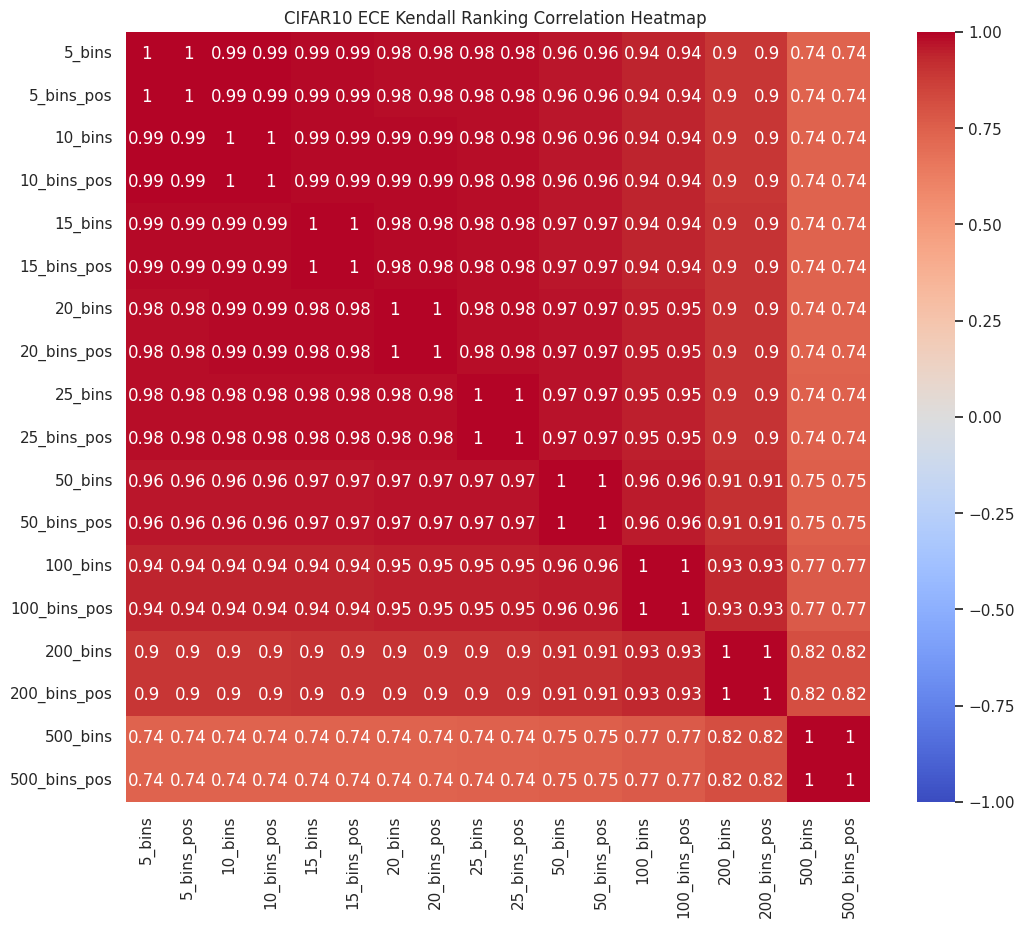

In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kendalltau

def nansafe_kendalltau(a, b):
    mask = ~(np.isnan(a) | np.isnan(b))
    return kendalltau(a[mask], b[mask])

# Extract bin columns from plot_df and plotpost_df
bin_columns = ['5_bins', '10_bins', '15_bins', '20_bins', '25_bins', '50_bins', '100_bins', '200_bins', '500_bins']

# Rename columns in plotpost_df to have a '_pos' suffix
plotpost_df = plotpost_df.rename(columns={col: f"{col}_pos" for col in bin_columns})

# Combine both DataFrames
combined_df = pd.concat([plot_df[bin_columns], plotpost_df], axis=1)

# Calculate the Kendall ranking correlation matrix for the combined DataFrame
all_columns = [col for col_pair in zip(bin_columns, [f"{col}_pos" for col in bin_columns]) for col in col_pair]
corr_matrix = pd.DataFrame(index=all_columns, columns=all_columns)

for col1 in all_columns:
    for col2 in all_columns:
        corr, _ = nansafe_kendalltau(combined_df[col1], combined_df[col2])
        corr_matrix.loc[col1, col2] = corr

# Create a correlation heatmap using seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix.astype(float), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("CIFAR10 ECE Kendall Ranking Correlation Heatmap ")
# plt.savefig("fig/Kendall_Ranking_Correlation_Heatmap_Between_Bin_Sizes_Two_DataFrames.pdf", dpi=300, format='pdf', bbox_inches='tight')
plt.show()

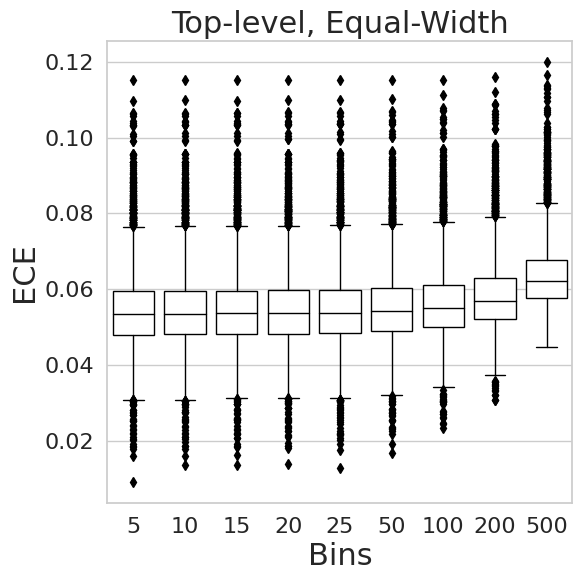

In [29]:



# Assuming ece_df is the DataFrame with columns '5_bins', '10_bins', '15_bins', etc.
sns.set(style="whitegrid")

plt.figure(figsize=(6, 6))

# Create a box plot for the ece_df DataFrame
sns.boxplot(data=plot_df.iloc[:, :-1],
            boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
            capprops=dict(color='black', linewidth=1),
            whiskerprops=dict(color='black', linewidth=1),
            medianprops=dict(color='black', linewidth=1),
            flierprops=dict(markeredgecolor='black', markerfacecolor='black', markersize=5))


# Set plot title and axis labels
plt.title("Top-level, Equal-Width", fontsize=title_font_size)
plt.xlabel("Bins", fontsize=axis_label_font_size)
plt.ylabel("ECE", fontsize=axis_label_font_size)

# Modify the x-axis tick labels
bin_numbers = [col.split('_')[0] for col in plot_df.columns[:-1]]
plt.xticks(range(len(bin_numbers)), bin_numbers,fontsize=tick_label_font_size)
plt.yticks(fontsize=tick_label_font_size)



# plt.savefig("fig/cifar10_toplevel_ew_ce.pdf", dpi=300, format='pdf', bbox_inches='tight')

# Show the plot
plt.show()

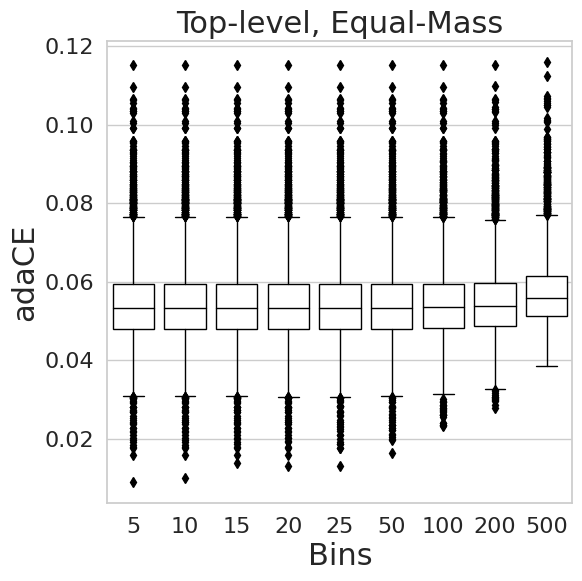

In [31]:
import pandas as pd

# Assuming `df` is your original DataFrame and 'ece' column contains list of dictionaries
# Create an empty DataFrame with desired columns
eceem_df = pd.DataFrame(columns=['5_bins', '10_bins', '15_bins', '20_bins', '25_bins', '50_bins', '100_bins', '200_bins', '500_bins','test-accuracy'])

# Iterate through the original DataFrame and extract the relevant information
for index, row in df.iterrows():
    ece_data = eval(row['ECE_em'])
    
    bins_data = {}
    for item in ece_data:
        bins_data[f"{item['num_bins']}_bins"] = item['result']
    
    bins_data['test-accuracy'] = row['info']*100
    
    # Append the extracted data to the new DataFrame
    
    data_to_append = pd.DataFrame([bins_data])
    eceem_df = pd.concat([eceem_df, data_to_append], ignore_index=True)

plot_df = eceem_df.loc[eceem_df['test-accuracy']>= 75]

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming ece_df is the DataFrame with columns '5_bins', '10_bins', '15_bins', etc.
sns.set(style="whitegrid")

plt.figure(figsize=(6, 6))
# Set font sizes

# Create a box plot for the ece_df DataFrame
sns.boxplot(data=plot_df.iloc[:, :-1],
            boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
            capprops=dict(color='black', linewidth=1),
            whiskerprops=dict(color='black', linewidth=1),
            medianprops=dict(color='black', linewidth=1),
            flierprops=dict(markeredgecolor='black', markerfacecolor='black', markersize=5))

# Set plot title and axis labels
plt.title("Top-level, Equal-Mass", fontsize=title_font_size)
plt.xlabel("Bins", fontsize=axis_label_font_size)
plt.ylabel("adaCE", fontsize=axis_label_font_size)

# Modify the x-axis tick labels
bin_numbers = [col.split('_')[0] for col in plot_df.columns[:-1]]
plt.xticks(range(len(bin_numbers)), bin_numbers,fontsize=tick_label_font_size)
plt.yticks(fontsize=tick_label_font_size)

# plt.savefig("fig/cifar10_toplevel_em_ce.pdf", dpi=300, format='pdf', bbox_inches='tight')
# Show the plot
plt.show()

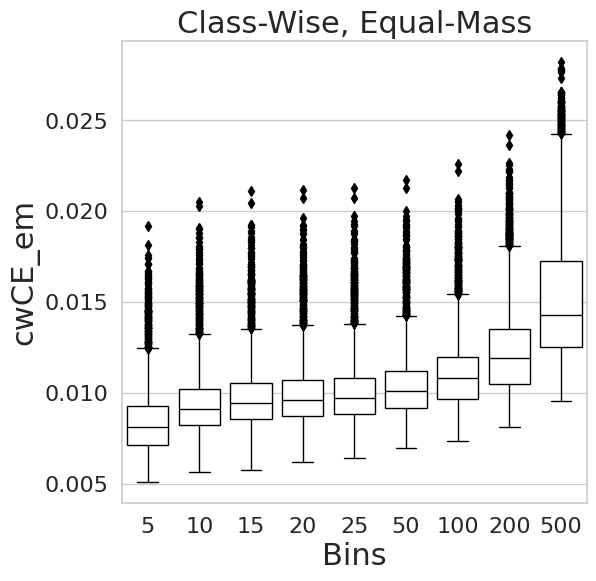

In [33]:
import pandas as pd

# Assuming `df` is your original DataFrame and 'ece' column contains list of dictionaries
# Create an empty DataFrame with desired columns
tace_df = pd.DataFrame(columns=['5_bins', '10_bins', '15_bins', '20_bins', '25_bins', '50_bins', '100_bins', '200_bins', '500_bins','test-accuracy'])

# Iterate through the original DataFrame and extract the relevant information
for index, row in df.iterrows():
    tace_data = eval(row['tace'])
    
    bins_data = {}
    for item in tace_data:
        bins_data[f"{item['n_bins']}_bins"] = item['result']
    
    bins_data['test-accuracy'] = row['info']*100
    
    # Append the extracted data to the new DataFrame
    
    data_to_append = pd.DataFrame([bins_data])
    tace_df = pd.concat([tace_df, data_to_append], ignore_index=True)
plot_df = tace_df.loc[tace_df['test-accuracy']>= 75]

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming ece_df is the DataFrame with columns '5_bins', '10_bins', '15_bins', etc.
sns.set(style="whitegrid")

plt.figure(figsize=(6, 6))

# Create a box plot for the ece_df DataFrame
sns.boxplot(data=plot_df.iloc[:, :-1],
            boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
            capprops=dict(color='black', linewidth=1),
            whiskerprops=dict(color='black', linewidth=1),
            medianprops=dict(color='black', linewidth=1),
            flierprops=dict(markeredgecolor='black', markerfacecolor='black', markersize=5))

# Set plot title and axis labels

# Set plot title and axis labels
plt.title("Class-Wise, Equal-Mass", fontsize=title_font_size)
plt.xlabel("Bins", fontsize=axis_label_font_size)
plt.ylabel("cwCE_em", fontsize=axis_label_font_size)

# Modify the x-axis tick labels
bin_numbers = [col.split('_')[0] for col in plot_df.columns[:-1]]
plt.xticks(range(len(bin_numbers)), bin_numbers,fontsize=tick_label_font_size)
plt.yticks(fontsize=tick_label_font_size)

# plt.savefig("fig/cifar10_classwise_em_ce.pdf", dpi=300, format='pdf', bbox_inches='tight')
# Show the plot
plt.show()



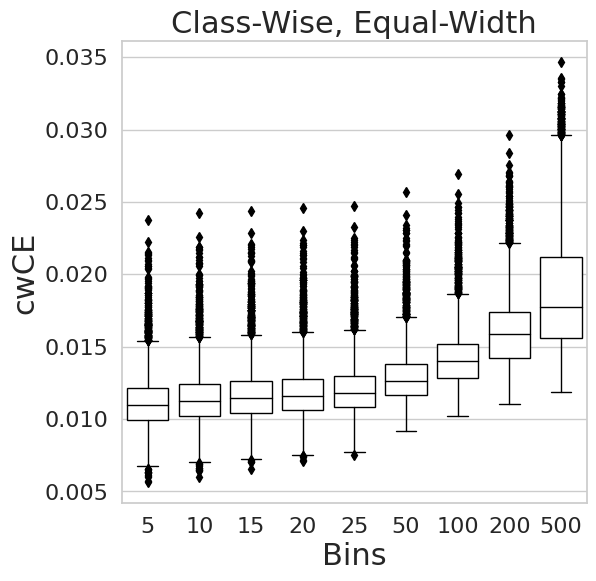

In [35]:
import pandas as pd

# Assuming `df` is your original DataFrame and 'ece' column contains list of dictionaries
# Create an empty DataFrame with desired columns
cwECE_df = pd.DataFrame(columns=['5_bins', '10_bins', '15_bins', '20_bins', '25_bins', '50_bins', '100_bins', '200_bins', '500_bins','test-accuracy'])

# Iterate through the original DataFrame and extract the relevant information
for index, row in df.iterrows():
    cwECE_data = eval(row['cwECE'])
    
    bins_data = {}
    for item in cwECE_data:
        bins_data[f"{item['n_bins']}_bins"] = item['result']
    
    bins_data['test-accuracy'] = row['info']*100
    
    # Append the extracted data to the new DataFrame
    
    data_to_append = pd.DataFrame([bins_data])
    cwECE_df = pd.concat([cwECE_df, data_to_append], ignore_index=True)

plot_df = cwECE_df.loc[cwECE_df['test-accuracy']>= 75]

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming ece_df is the DataFrame with columns '5_bins', '10_bins', '15_bins', etc.
sns.set(style="whitegrid")

plt.figure(figsize=(6, 6))

# Create a box plot for the ece_df DataFrame
sns.boxplot(data=plot_df.iloc[:, :-1],
            boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
            capprops=dict(color='black', linewidth=1),
            whiskerprops=dict(color='black', linewidth=1),
            medianprops=dict(color='black', linewidth=1),
            flierprops=dict(markeredgecolor='black', markerfacecolor='black', markersize=5))



# Set plot title and axis labels
plt.title("Class-Wise, Equal-Width", fontsize=title_font_size)
plt.xlabel("Bins", fontsize=axis_label_font_size)
plt.ylabel("cwCE", fontsize=axis_label_font_size)

# Modify the x-axis tick labels
bin_numbers = [col.split('_')[0] for col in plot_df.columns[:-1]]
plt.xticks(range(len(bin_numbers)), bin_numbers,fontsize=tick_label_font_size)
plt.yticks(fontsize=tick_label_font_size)


plt.savefig("fig/cifar10_classwise_ew_ce.pdf", dpi=300, format='pdf', bbox_inches='tight')
# Show the plot
plt.show()



/home/younan/anaconda3/envs/pytorch_3.7/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/younan/anaconda3/envs/pytorch_3.7/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/younan/anaconda3/envs/pytorch_3.7/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/younan/anaconda3/envs/pytorch_3.7/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator


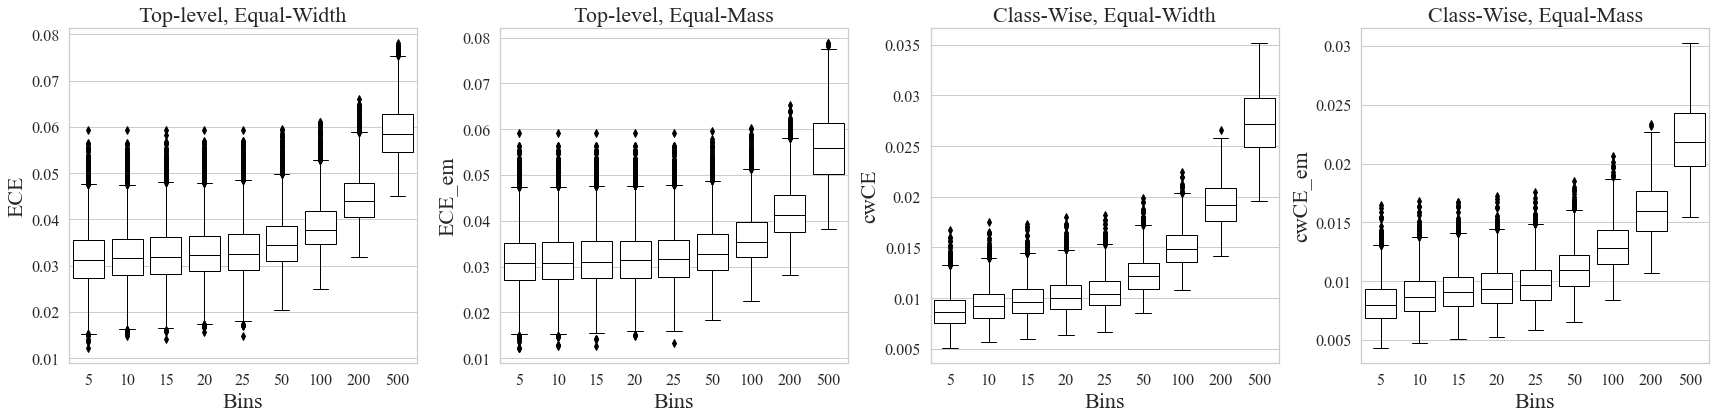

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming ece_df, eceem_df, tace_df, cwECE_df are the DataFrames with columns '5_bins', '10_bins', '15_bins', etc.
plot_df_list = [ece_df, eceem_df, cwECE_df, tace_df]
titles = ["Top-level, Equal-Width", "Top-level, Equal-Mass", "Class-Wise, Equal-Width", "Class-Wise, Equal-Mass"]
ylabels = ["ECE", "ECE_em", "cwCE", "cwCE_em"]

# Create a 1x4 grid of subplots
fig, axes = plt.subplots(1, 4, figsize=(24, 6))
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'

sns.set(style="whitegrid")

for i, plot_df in enumerate(plot_df_list):
    col = i
    ax = axes[col]

    # Filter data by test-accuracy
    plot_df_filtered = plot_df.loc[plot_df['test-accuracy'] >= 75].iloc[:, :-1]

    # Create a box plot for the plot_df DataFrame
    sns.boxplot(data=plot_df_filtered,
                ax=ax,
                boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
                capprops=dict(color='black', linewidth=1),
                whiskerprops=dict(color='black', linewidth=1),
                medianprops=dict(color='black', linewidth=1),
                flierprops=dict(markeredgecolor='black', markerfacecolor='black', markersize=5))

    # Set plot title and axis labels
    ax.set_title(titles[i], fontsize=title_font_size)
    ax.set_xlabel("Bins", fontsize=axis_label_font_size)
    ax.set_ylabel(ylabels[i], fontsize=axis_label_font_size)

    # Modify the x-axis tick labels
    bin_numbers = [col.split('_')[0] for col in plot_df.columns[:-1]]
    ax.set_xticklabels(bin_numbers, fontsize=tick_label_font_size)
    ax.set_yticklabels(ax.get_yticks(), fontsize=tick_label_font_size)

# Adjust spacing between subplots
fig.tight_layout()

# Save the figure
plt.savefig("fig/cifar10_combined_plots_single_row.pdf", dpi=300, format='pdf', bbox_inches='tight')

# Show the figure
plt.show()

/tmp/ipykernel_2425318/17750563.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.2f}'.format(tick) for tick in ax.get_yticks()], fontsize=tick_label_font_size)
/tmp/ipykernel_2425318/17750563.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.2f}'.format(tick) for tick in ax.get_yticks()], fontsize=tick_label_font_size)
/tmp/ipykernel_2425318/17750563.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.2f}'.format(tick) for tick in ax.get_yticks()], fontsize=tick_label_font_size)
/tmp/ipykernel_2425318/17750563.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.2f}'.format(tick) for tick in ax.get_yticks()], fontsize=tick_label_font_size)


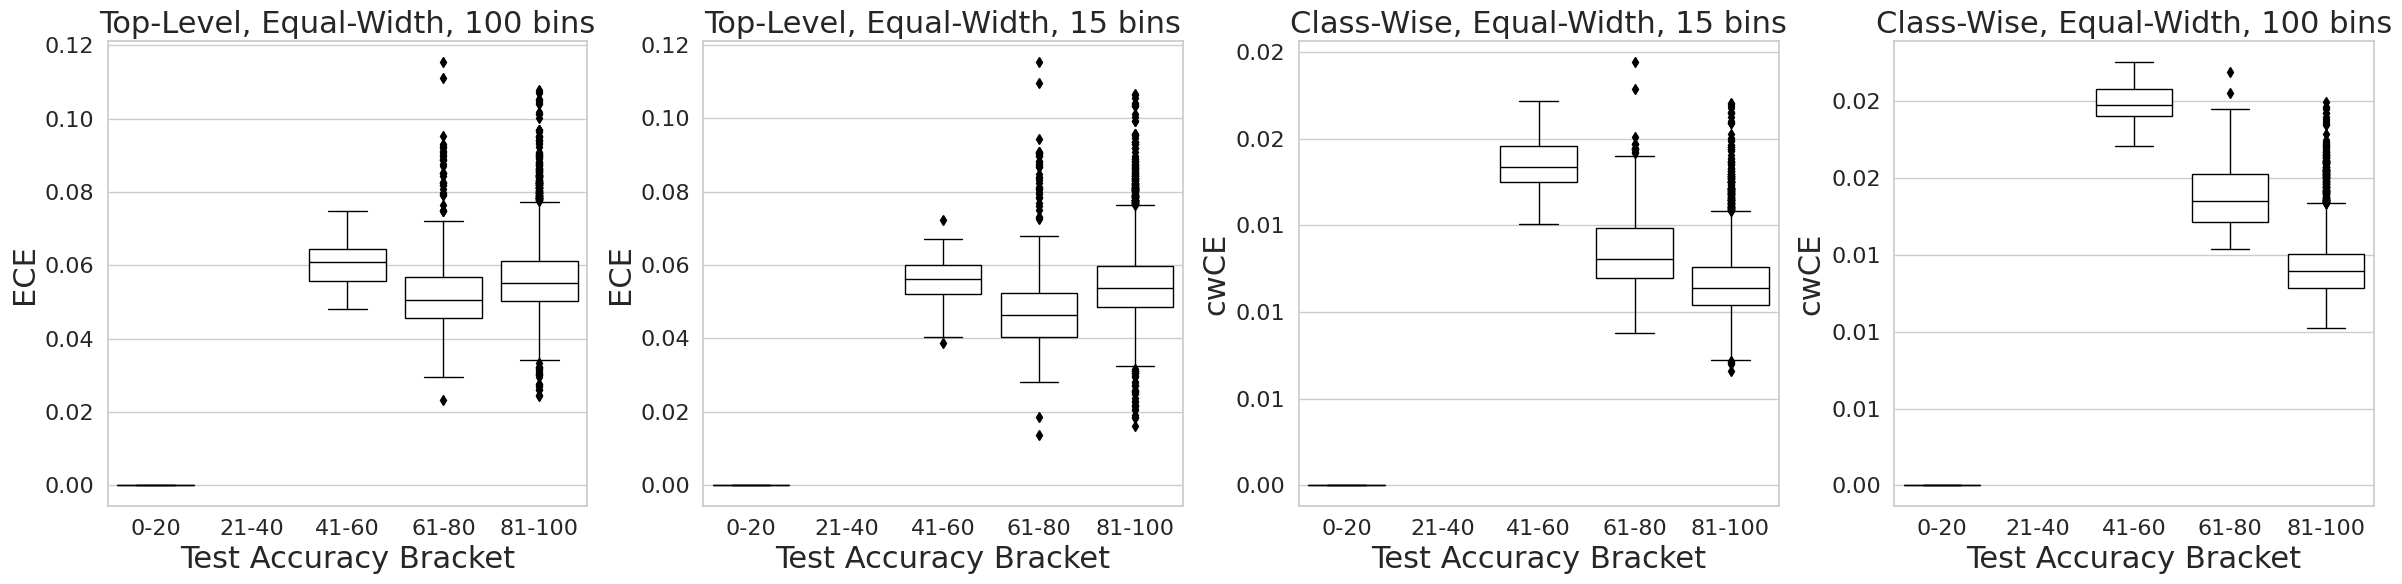

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming ece_df and cwECE_df are your dataframes

def categorize_test_accuracy(accuracy):
    if 0 <= accuracy <= 20:
        return '0-20'
    elif 20 < accuracy <= 40:
        return '21-40'
    elif 40 < accuracy <= 60:
        return '41-60'
    elif 60 < accuracy <= 80:
        return '61-80'
    else:
        return '81-100'

ece_df['accuracy_bracket'] = ece_df['test-accuracy'].apply(categorize_test_accuracy)
cwECE_df['accuracy_bracket'] = cwECE_df['test-accuracy'].apply(categorize_test_accuracy)

# Create a 1x4 grid of subplots
fig, axes = plt.subplots(1, 4, figsize=(24, 6))

sns.set(style="whitegrid")

titles = [
    "Top-Level, Equal-Width, 100 bins",
    "Top-Level, Equal-Width, 15 bins",
    "Class-Wise, Equal-Width, 15 bins",
    "Class-Wise, Equal-Width, 100 bins"
]

ylabels = ["ECE", "ECE", "cwCE", "cwCE"]
bins = ['100_bins', '15_bins', '15_bins', '100_bins']
dataframes = [ece_df, ece_df, cwECE_df, cwECE_df]

for i, (df, bin_col) in enumerate(zip(dataframes, bins)):
    ax = axes[i]

    plot_data = []
    for bracket in ['0-20', '21-40', '41-60', '61-80', '81-100']:
        plot_data.append(df.loc[df['accuracy_bracket'] == bracket, bin_col])

    sns.boxplot(data=plot_data,
                ax=ax,
                boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
                capprops=dict(color='black', linewidth=1),
                whiskerprops=dict(color='black', linewidth=1),
                medianprops=dict(color='black', linewidth=1),
                flierprops=dict(markeredgecolor='black', markerfacecolor='black', markersize=5))

    ax.set_title(titles[i], fontsize=title_font_size)
    ax.set_xlabel("Test Accuracy Bracket", fontsize=axis_label_font_size)
    ax.set_ylabel(ylabels[i], fontsize=axis_label_font_size)

    ax.set_xticklabels(['0-20', '21-40', '41-60', '61-80', '81-100'], fontsize=tick_label_font_size)
    ax.set_yticklabels(['{:.2f}'.format(tick) for tick in ax.get_yticks()], fontsize=tick_label_font_size)
# Adjust spacing between subplots
fig.tight_layout()

# Save the figure
plt.savefig("fig/cifar10_new_combined_plots_single_row.pdf", dpi=300, format='pdf', bbox_inches='tight')

# Show the figure
plt.show()

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming ece_df is your dataframe

# Create a new column to categorize test accuracy into 5 brackets
def categorize_test_accuracy(accuracy):
    if 0 <= accuracy <= 20:
        return '0-20'
    elif 20 < accuracy <= 40:
        return '21-40'
    elif 40 < accuracy <= 60:
        return '41-60'
    elif 60 < accuracy <= 80:
        return '61-80'
    else:
        return '81-100'

ece_df['accuracy_bracket'] = ece_df['test-accuracy'].apply(categorize_test_accuracy)

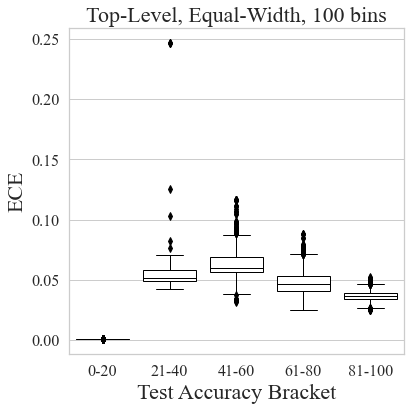

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plot_data = []
for bracket in ['0-20', '21-40', '41-60', '61-80', '81-100']:
    plot_data.append(ece_df.loc[ece_df['accuracy_bracket'] == bracket, '100_bins'])

# Creating the box plot
sns.set(style="whitegrid")
plt.figure(figsize=(6, 6))
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'

sns.boxplot(data=plot_data,
            boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
            capprops=dict(color='black', linewidth=1),
            whiskerprops=dict(color='black', linewidth=1),
            medianprops=dict(color='black', linewidth=1),
            flierprops=dict(markeredgecolor='black', markerfacecolor='black', markersize=5))

# Set font sizes

# Set plot title and axis labels
plt.title("Top-Level, Equal-Width, 100 bins", fontsize=title_font_size)
plt.xlabel("Test Accuracy Bracket", fontsize=axis_label_font_size)
plt.ylabel("ECE", fontsize=axis_label_font_size)

# Modify the x-axis tick labels
plt.xticks(range(len(['0-20', '21-40', '41-60', '61-80', '81-100'])), ['0-20', '21-40', '41-60', '61-80', '81-100'],fontsize=tick_label_font_size)
plt.yticks(fontsize=tick_label_font_size)

plt.savefig("fig/cifar10_100_bins_TopLevelEWBCE_on_different_Accuracy.pdf", dpi=300, format='pdf', bbox_inches='tight')
# Show the plot
plt.show()

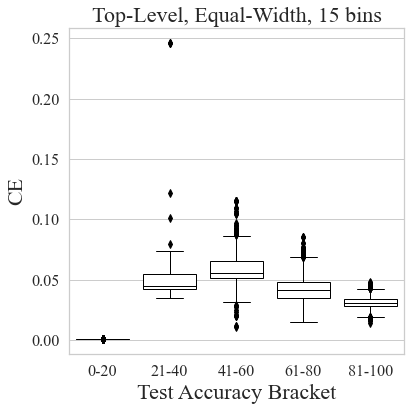

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plot_data = []
for bracket in ['0-20', '21-40', '41-60', '61-80', '81-100']:
    plot_data.append(ece_df.loc[ece_df['accuracy_bracket'] == bracket, '15_bins'])

# Creating the box plot
sns.set(style="whitegrid")
plt.figure(figsize=(6, 6))
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'

sns.boxplot(data=plot_data,
            boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
            capprops=dict(color='black', linewidth=1),
            whiskerprops=dict(color='black', linewidth=1),
            medianprops=dict(color='black', linewidth=1),
            flierprops=dict(markeredgecolor='black', markerfacecolor='black', markersize=5))


# Set plot title and axis labels
plt.title("Top-Level, Equal-Width, 15 bins", fontsize=title_font_size)
plt.xlabel("Test Accuracy Bracket", fontsize=axis_label_font_size)
plt.ylabel("CE", fontsize=axis_label_font_size)

# Modify the x-axis tick labels
plt.xticks(range(len(['0-20', '21-40', '41-60', '61-80', '81-100'])), ['0-20', '21-40', '41-60', '61-80', '81-100'],fontsize=tick_label_font_size)
plt.yticks(fontsize=tick_label_font_size)

plt.savefig("fig/cifar10_15_bins_TopLevelEWBCE_on_different_Accuracy.pdf", dpi=300, format='pdf', bbox_inches='tight')
# Show the plot
plt.show()

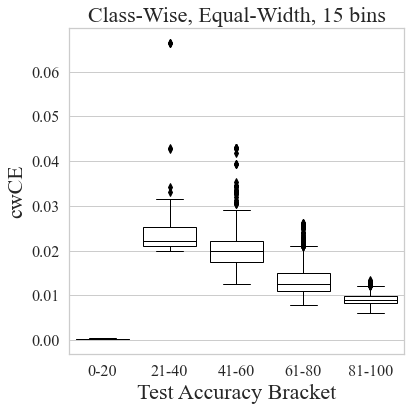

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming ece_df is your dataframe

# Create a new column to categorize test accuracy into 5 brackets
def categorize_test_accuracy(accuracy):
    if 0 <= accuracy <= 20:
        return '0-20'
    elif 20 < accuracy <= 40:
        return '21-40'
    elif 40 < accuracy <= 60:
        return '41-60'
    elif 60 < accuracy <= 80:
        return '61-80'
    else:
        return '81-100'

cwECE_df['accuracy_bracket'] = cwECE_df['test-accuracy'].apply(categorize_test_accuracy)

import seaborn as sns
import matplotlib.pyplot as plt

plot_data = []
for bracket in ['0-20', '21-40', '41-60', '61-80', '81-100']:
    plot_data.append(cwECE_df.loc[cwECE_df['accuracy_bracket'] == bracket, '15_bins'])

# Creating the box plot
sns.set(style="whitegrid")
plt.figure(figsize=(6, 6))
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'

sns.boxplot(data=plot_data,
            boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
            capprops=dict(color='black', linewidth=1),
            whiskerprops=dict(color='black', linewidth=1),
            medianprops=dict(color='black', linewidth=1),
            flierprops=dict(markeredgecolor='black', markerfacecolor='black', markersize=5))

plt.title("Class-Wise, Equal-Width, 15 bins", fontsize=title_font_size)
plt.xlabel("Test Accuracy Bracket", fontsize=axis_label_font_size)
plt.ylabel("cwCE", fontsize=axis_label_font_size)

# Modify the x-axis tick labels
plt.xticks(range(len(['0-20', '21-40', '41-60', '61-80', '81-100'])), ['0-20', '21-40', '41-60', '61-80', '81-100'],fontsize=tick_label_font_size)
plt.yticks(fontsize=tick_label_font_size)

plt.savefig("fig/cifar10_15_bins_cwEWBCE_on_different_Accuracy.pdf", dpi=300, format='pdf', bbox_inches='tight')
# Show the plot
plt.show()

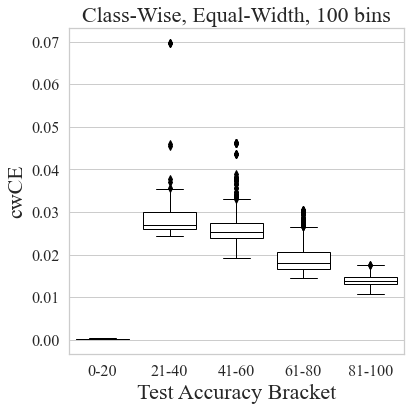

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming ece_df is your dataframe

# Create a new column to categorize test accuracy into 5 brackets
def categorize_test_accuracy(accuracy):
    if 0 <= accuracy <= 20:
        return '0-20'
    elif 20 < accuracy <= 40:
        return '21-40'
    elif 40 < accuracy <= 60:
        return '41-60'
    elif 60 < accuracy <= 80:
        return '61-80'
    else:
        return '81-100'

cwECE_df['accuracy_bracket'] = cwECE_df['test-accuracy'].apply(categorize_test_accuracy)

import seaborn as sns
import matplotlib.pyplot as plt

plot_data = []
for bracket in ['0-20', '21-40', '41-60', '61-80', '81-100']:
    plot_data.append(cwECE_df.loc[cwECE_df['accuracy_bracket'] == bracket, '100_bins'])

# Creating the box plot
sns.set(style="whitegrid")
plt.figure(figsize=(6, 6))
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'

sns.boxplot(data=plot_data,
            boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
            capprops=dict(color='black', linewidth=1),
            whiskerprops=dict(color='black', linewidth=1),
            medianprops=dict(color='black', linewidth=1),
            flierprops=dict(markeredgecolor='black', markerfacecolor='black', markersize=5))

plt.title("Class-Wise, Equal-Width, 100 bins", fontsize=title_font_size)
plt.xlabel("Test Accuracy Bracket", fontsize=axis_label_font_size)
plt.ylabel("cwCE", fontsize=axis_label_font_size)

# Modify the x-axis tick labels
plt.xticks(range(len(['0-20', '21-40', '41-60', '61-80', '81-100'])), ['0-20', '21-40', '41-60', '61-80', '81-100'],fontsize=tick_label_font_size)
plt.yticks(fontsize=tick_label_font_size)

plt.savefig("fig/cifar10_100_bins_cwEWBCE_on_different_Accuracy.pdf", dpi=300, format='pdf', bbox_inches='tight')
# Show the plot
plt.show()